In [1]:
# Set up

import numpy as np
import pandas as pd

# Data management & cleaning
import json # to load json files
import gc # to delete files from cache
import os #to get file names in directory
import random #for random sampling of files
import pickle #to save lists
import glob
import statsmodels.api as sm

#pip install pyarrow

# Analysis
import spacy # for named entity recognition

import en_core_web_sm #https://github.com/explosion/spaCy/issues/4577
import country_converter as coco #https://pypi.org/project/country-converter/ #pip install country_converter --upgrade
from sklearn.preprocessing import MultiLabelBinarizer
import re #regular expressions
import pycountry # for regular expresison country names
import wbgapi as wb


# Visualization
import matplotlib.pyplot as plt


path="C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/03_output/csv/"
mturk_path = "C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/01_raw_data/classification_set/"

save_file="C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/03_output/country_classifications.csv"
country_file="C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/03_output/country_scores.csv"

In [2]:
print(glob.glob(os.path.join(path, "*.csv")))

['C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/03_output/csv\\metadata_0.csv', 'C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/03_output/csv\\metadata_1.csv', 'C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/03_output/csv\\metadata_10.csv', 'C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/03_output/csv\\metadata_2.csv', 'C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/03_output/csv\\metadata_3.csv', 'C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/03_output/csv\\metadata_4.csv', 'C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/03_output/csv\\metadata_5.csv', 'C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/03_output/csv\\metadata_6.csv', 'C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/03_o

In [3]:
#read in the data
all_files = glob.glob(os.path.join(path, "*.csv"))
all_files = ['C:/Users/wb469649/OneDrive - WBG/DECIS/SPI/Academia_Data_Use/Data/s2orc_data_use/03_output/csv\\metadata_6.csv']

df_pd = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
df_pd = df_pd[df_pd['abstract'].notna()]


df_pd=df_pd[['paper_id','title','abstract','year','doi', 'venue', 'journal','mag_field_of_study']]

C:\Users\wb469649\AppData\Local\Temp\ipykernel_13568\3725643286.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pd = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)


In [4]:
# Show example text
%time
df_pd["abstract"][1000]

CPU times: total: 0 ns
Wall time: 0 ns


'Carotenoid cleavage oxygenases (CCOs) are non-heme iron enzymes that catalyze scission of alkene groups in carotenoids and stilbenoids to form biologically important products. CCOs possess a rare four-His iron center whose resting-state structure and interaction with substrates are incompletely understood. Here, we address this knowledge gap through a comprehensive structural and spectroscopic study of three phyletically diverse CCOs. The crystal structure of a fungal stilbenoid-cleaving CCO, CAO1, reveals strong similarity between its iron center and those of carotenoid-cleaving CCOs, but with a markedly different substrate-binding cleft. These enzymes all possess a five-coordinate high-spin Fe(II) center with resting-state Fe-His bond lengths of ∼2.15 Å. This ligand set generates an iron environment more electropositive than those of other non-heme iron dioxygenases as observed by Mössbauer isomer shifts. Dioxygen (O2) does not coordinate iron in the absence of substrate. Substrates

In [5]:
#extract GPE
paper_index = list(df_pd.index) # this ist just a list of the index/CoreIDs
nlp = en_core_web_sm.load() #load model; https://github.com/explosion/spaCy/issues/4577
#nlp = spacy.load("en_core_web_sm") # load model

In [6]:
%%time

# a problem here is that the extracted GPEs are saved as lists within the dataframe and I think 
# that takes up a lot of memory
# but in the next step we actually need them as list, so converting it to strings is not really a solution

# https://stackoverflow.com/questions/44395656/applying-spacy-parser-to-pandas-dataframe-w-multiprocessing
#https://spacy.io/api/language#pipe

places = []
counter = 0
manual_batch_size = 10000

for doc in nlp.pipe(df_pd.loc[paper_index,'abstract'].astype('unicode').values,
                    batch_size=20,
                    #n_threads=8,
                    n_process = -1,
                    disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]): 
    
    if len(doc.ents) != 0:
        places.append([ent.as_doc() for ent in doc.ents if ent.label_ in ['GPE']])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        places.append([])
    
    # Creating ONE list of all the extracted GPEs took up too much memory, leading the kernel to die.
    # Therfore, I am saving the results from every 1000 publications directly to the dataframe,
    # and then clear the list.
    if (len(places)%manual_batch_size == 0):
        df_pd.loc[paper_index[(counter*manual_batch_size):(manual_batch_size*(counter + 1))],'places'] = places
        counter += 1
        print(counter/(df_pd.shape[0]/manual_batch_size)) # print out progress
        del places
        gc.collect()
        places = []

C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\dtypes\missing.py:550: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.array(val, copy=False)
C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundat

0.10609629299552274


C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\internals\blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


0.21219258599104548


C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\internals\blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


0.3182888789865682


C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\internals\blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


0.42438517198209097


C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\internals\blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


0.5304814649776137


C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\internals\blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


0.6365777579731364


C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\internals\blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


0.7426740509686591


C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\internals\blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


0.8487703439641819


C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:3199: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim
C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\internals\blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


0.9548666369597046
CPU times: total: 5min 9s
Wall time: 6min 15s


Standardize country names

In [7]:
%%capture
# use country converter to standarize country names
countries = coco.convert(names=df_pd.loc[paper_index,"places"], to='ISO3', src ="regex", not_found = "nf")
df_pd.loc[paper_index,'countries'] = countries

In [8]:
df_pd[['paper_id','title','abstract', 'places', 'countries']].head(25)

,paper_id,title,abstract,places,countries
0,77497168,"Italy, Secret Treaty of London and the Albania...",Through this work we aim to analyze the Italia...,"[(Italy), (Italy), (Albania)]","[ALB, ITA]"
1,77499685,Pulmonary Involvement In Sweet’s Syndrome: A C...,There have been many reported cases of Acute F...,"[(Sweet), (Sweet)]",nf
2,159356771,Challenges for agricultural policy in the serv...,During last decades the essential shift occurr...,[],nf
3,159356789,LOCAL GOVERNMENT AND POLICY NETWORKS IN THE UK...,"In the United Kingdom, local government includ...","[(the, United, Kingdom), (The, United, Kingdom...","[GBR, USA]"
4,159356932,Alternative measures of macroeconomic imbalanc...,Years 2008 and 2009 were particularly affected...,"[(EU), (Gugler)]",nf
5,18981067,The Essence of ATP Coupling,The traditional explanation of ATP coupling is...,[],nf
6,18982009,Polycomb Group Protein Bmi1 Is Required for Gr...,BACKGROUND ::: We have previously described a ...,[],nf
7,18982484,Future Challenges in Nocturia: Relevance to Vo...,Sleep is a naturally stereotypical behavioral ...,[],nf
8,18983204,"Effects of the Cyclooxygenase Inhibitor, Pirox...",The objectives of this study were: ( a ) to de...,[],nf
9,18984284,Participation and Engagement in Inter-organiza...,A network ethnography methodology was develope...,[],nf


#### Get dummies

Unfortunately, the output of country-convert is none conistent. Sometimes the type is list, sometimes str, sometimes none.

In [9]:
%%time
for i in paper_index: #len(df_pd)
    if type(df_pd.loc[i,'countries']) == str:
        df_pd.at[i,"countries"] = df_pd.loc[i,'countries'].split()

CPU times: total: 1.88 s
Wall time: 1.89 s


In [10]:
%%time
# Get dummies
#Inspiration: https://stackoverflow.com/questions/29034928/pandas-convert-a-column-of-list-to-dummies 
#Inspiration: https://stackoverflow.com/questions/47209847/is-there-a-method-for-creating-dataframe-of-dummy-variables-from-a-dictionary-of
s = df_pd.loc[paper_index,'countries']
mlb = MultiLabelBinarizer()
df_c = pd.DataFrame(mlb.fit_transform(s),columns=mlb.classes_, index=paper_index)

#merge with df_pd
df_final = pd.concat([df_pd, df_c], axis=1)
df_final.head()


CPU times: total: 266 ms
Wall time: 266 ms


,paper_id,title,abstract,year,doi,venue,journal,mag_field_of_study,places,countries,...,VGB,VIR,VNM,VUT,XKX,YEM,ZAF,ZMB,ZWE,nf
0,77497168,"Italy, Secret Treaty of London and the Albania...",Through this work we aim to analyze the Italia...,2016,10.5901/ajis.2016.v5n2p219,NaN,Academic Journal of Interdisciplinary Studies,NaN,"[(Italy), (Italy), (Albania)]","[ALB, ITA]",...,0,0,0,0,0,0,0,0,0,0
1,77499685,Pulmonary Involvement In Sweet’s Syndrome: A C...,There have been many reported cases of Acute F...,2014,NaN,NaN,The Internet Journal of Pulmonary Medicine,NaN,"[(Sweet), (Sweet)]",[nf],...,0,0,0,0,0,0,0,0,0,1
2,159356771,Challenges for agricultural policy in the serv...,During last decades the essential shift occurr...,2018,10.5937/ekoPolj1804545V,NaN,Ekonomika Poljoprivrede (1979),NaN,[],[nf],...,0,0,0,0,0,0,0,0,0,1
3,159356789,LOCAL GOVERNMENT AND POLICY NETWORKS IN THE UK...,"In the United Kingdom, local government includ...",2018,10.22363/2313-1438-2018-20-4-516-524,RUDN Journal of Political Science,RUDN Journal of Political Science,NaN,"[(the, United, Kingdom), (The, United, Kingdom...","[GBR, USA]",...,0,0,0,0,0,0,0,0,0,0
4,159356932,Alternative measures of macroeconomic imbalanc...,Years 2008 and 2009 were particularly affected...,2018,10.15240/tul/001/2019-1-003,NaN,E & M Ekonomie A Management,NaN,"[(EU), (Gugler)]",[nf],...,0,0,0,0,0,0,0,0,0,1


In [11]:
# Save data
df_final.reset_index().to_csv(save_file)


In [12]:
df_s = df_c.sum().to_frame(name = "papers")

# Show 50 countries with highest number of publications
df_s = df_s.sort_values(by = "papers", ascending = False)
df_s.head(50)



,papers
nf,82055
USA,1420
CHN,1091
IND,712
AUS,546
JPN,489
CAN,480
DEU,469
BRA,394
IRN,368


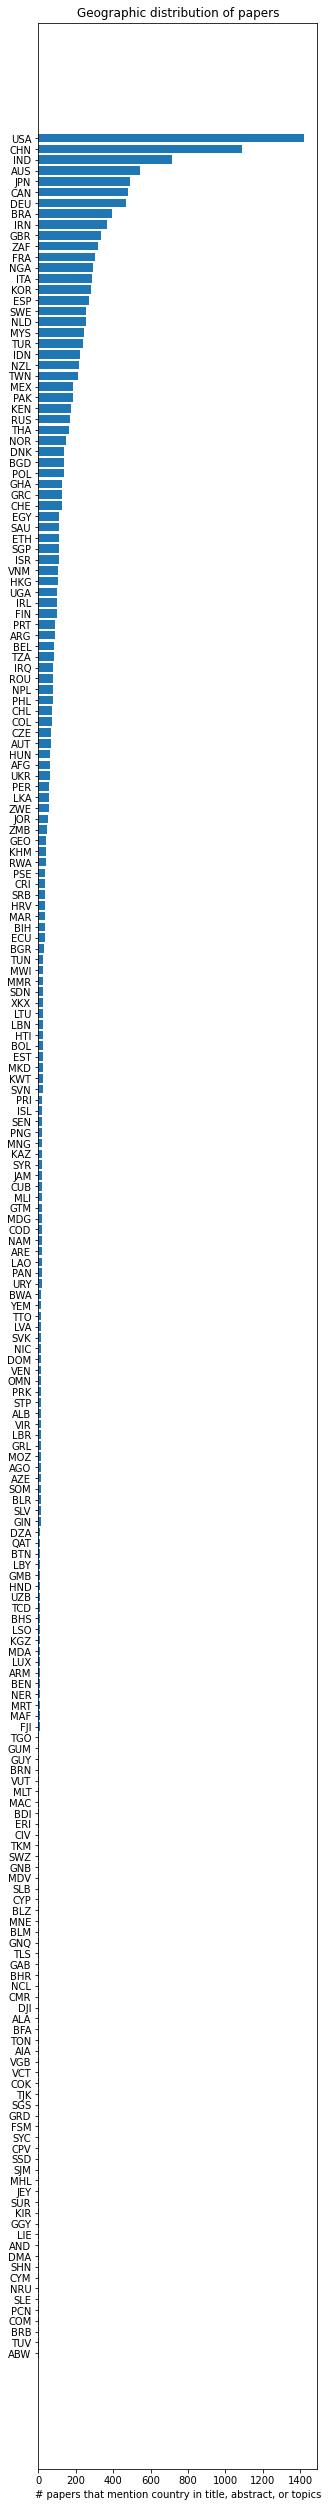

In [13]:
# Bar graph of countries without NF
fig, ax = plt.subplots(figsize =(5,45))
y_pos = np.arange(df_s[df_s.index[1]:].shape[0])
ax.barh(y_pos,df_s[df_s.index[1]:].papers.values)
ax.set_yticks(y_pos)
ax.set_yticklabels(df_s[df_s.index[1]:].index)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('# papers that mention country in title, abstract, or topics')
ax.set_title('Geographic distribution of papers')
plt.show()


In [14]:
#download data from World Bank on population and GDP per capita, PPP (2017 dollars) using API
wdi_df = wb.data.DataFrame(['SP.POP.TOTL','NY.GDP.PCAP.PP.KD','NY.GDP.MKTP.PP.KD', 'IQ.SPI.OVRL'], time=2019, labels=True).reset_index()

#set index to econonies
wdi_df.set_index('economy', inplace=True)

wdi_df.head()

C:\Users\wb469649\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\wbgapi\data.py:327: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dummy = pd.Series()    # empty series - never assigned actual values


,Country,IQ.SPI.OVRL,NY.GDP.MKTP.PP.KD,NY.GDP.PCAP.PP.KD,SP.POP.TOTL
economy,,,,,
ZWE,Zimbabwe,61.652500,3.384034e+10,2310.634802,14645473.0
ZMB,Zambia,59.014167,6.198557e+10,3470.435511,17861034.0
YEM,"Yemen, Rep.",36.771250,NaN,NaN,29161922.0
PSE,West Bank and Gaza,70.429583,2.926184e+10,6245.448697,4685306.0
VIR,Virgin Islands (U.S.),NaN,NaN,NaN,106669.0


In [15]:
#merge wdi_df with df_s 
df_merged = pd.concat([df_s, wdi_df], axis=1)


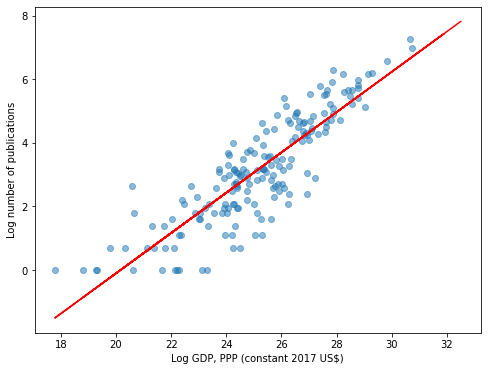

In [16]:
# Scatter of GDP pc and number of publications
x = np.log(df_merged["NY.GDP.MKTP.PP.KD"].values)
y = np.log(df_merged["papers"].values)
idx = np.isfinite(x) & np.isfinite(y) # to exclude observations with nan in wdi data
m,b = np.polyfit(x[idx], y[idx], 1)
plt.figure(figsize=(8, 6))
plt.scatter(x, y,  alpha=0.5) #s=area, c=colors,
plt.plot(x, m*x + b, color = "red")
plt.xlabel("Log GDP, PPP (constant 2017 US$)")
plt.ylabel("Log number of publications")
plt.show()

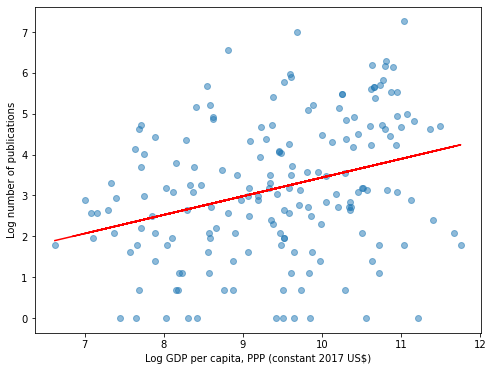

In [17]:
# Scatter of GDP pc and number of publications
x = np.log(df_merged["NY.GDP.PCAP.PP.KD"].values)
y = np.log(df_merged["papers"].values)
idx = np.isfinite(x) & np.isfinite(y) # to exclude observations with nan in wdi data
m,b = np.polyfit(x[idx], y[idx], 1)
plt.figure(figsize=(8, 6))
plt.scatter(x, y,  alpha=0.5) #s=area, c=colors,
plt.plot(x, m*x + b, color = "red")
plt.xlabel("Log GDP per capita, PPP (constant 2017 US$)")
plt.ylabel("Log number of publications")
plt.show()

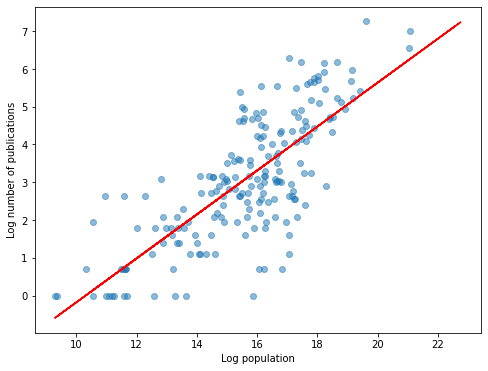

In [18]:
# Scatter of population and number of publications
x = np.log(df_merged["SP.POP.TOTL"].values)
y = np.log(df_merged["papers"].values)
idx = np.isfinite(x) & np.isfinite(y) # to exclude observations with nan in wdi data
m,b = np.polyfit(x[idx], y[idx], 1)
plt.figure(figsize=(8, 6))
plt.scatter(x, y,  alpha=0.5) #s=area, c=colors,
plt.plot(x, m*x + b, color = "red")
plt.xlabel("Log population")
plt.ylabel("Log number of publications")
plt.show()

## Classify Papers by Country - Regular Expressions


In [19]:
# get list of all countries and subdivisions
country_dict = {} 
to_be_removed = ["West", "East", "Center","Centre","North","South",
                 "Western","Eastern","Southern","Northern","Central",
                 "Ouest", "Est", "Sud", "Est", "Nord","Centre-Est","Centre-Sud","Centre-Ouest","Centre-Nord",
                 "Norte", "Este", "Sur", "Oeste",
                 "Has", "Ha", "Male", "Mat", "Delta", "Leon","León","Como","Para","Most","Pool"] #MAT, relevant for subdivisions
for country in pycountry.countries:
    entities = ["\s" + country.name + "[\s,.:]"]
    # THIS CODE IS FOR SUBDIVISIONS: (commented because too slow)
    #for sub_div in pycountry.subdivisions.get(country_code = country.alpha_2):
    #    if sub_div.name not in to_be_removed:
    #    #adding spaces before and allowing for max 1 or zero characters afters (e.g. a comma),
    #    # otherwise segments being picked up
    #        entities.append("\s" + sub_div.name + "[\s,.:]")  
    country_dict[country.alpha_3] = entities

In [20]:
def check_if_country_or_subdiv_present(df, name_of_text_column, country_code_alpha3):
    df_matrix = pd.DataFrame(index=df.index)
    for entity in country_dict[country_code_alpha3]:
        df_matrix[entity] = df[name_of_text_column].str.contains(entity, flags=re.IGNORECASE, regex=True).astype(int)
    df_matrix["present"] = df_matrix.max(axis=1)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(df_matrix.sum()) #turn on to analyze sub-div level results
    return df_matrix["present"]
    del df_matrix
    gc.collect()

In [21]:
%time
for country_code_alpha3 in country_dict.keys():
#for country_code_alpha3 in ["ARG"]:
    column_name = country_code_alpha3 + "_regex"
    df_c[column_name] = check_if_country_or_subdiv_present(df_pd, "abstract", country_code_alpha3)
    # Take the maximum SpaCy and %regex detection
    # print("here with", country_code_alpha3)
    if country_code_alpha3 in df_c.columns: #if we already made a column with spacy, combine (inclusively) the results
        df_c[country_code_alpha3] = df_c[[country_code_alpha3,column_name]].max(axis=1) 
        df_c = df_c.drop(columns = [column_name])
    else:
        df_c[country_code_alpha3] = df_c[column_name]
        df_c = df_c.drop(columns = [column_name]) 

CPU times: total: 0 ns
Wall time: 0 ns
\sAruba[\s,.:]    1
present           1
dtype: int64
\sAfghanistan[\s,.:]    57
present                 57
dtype: int64
\sAngola[\s,.:]    11
present            11
dtype: int64
\sAnguilla[\s,.:]    5
present              5
dtype: int64
\sÅland Islands[\s,.:]    1
present                   1
dtype: int64
\sAlbania[\s,.:]    15
present             15
dtype: int64
\sAndorra[\s,.:]    1
present             1
dtype: int64
\sUnited Arab Emirates[\s,.:]    20
present                          20
dtype: int64
\sArgentina[\s,.:]    85
present               85
dtype: int64
\sArmenia[\s,.:]    9
present             9
dtype: int64
\sAmerican Samoa[\s,.:]    0
present                    0
dtype: int64
\sAntarctica[\s,.:]    15
present                15
dtype: int64
\sFrench Southern Territories[\s,.:]    0
present                                 0
dtype: int64
\sAntigua and Barbuda[\s,.:]    0
present                         0
dtype: int64
\sAustralia[\s,.:]   

C:\Users\wb469649\AppData\Local\Temp\ipykernel_13568\3580556924.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_matrix[entity] = df[name_of_text_column].str.contains(entity, flags=re.IGNORECASE, regex=True).astype(int)


\sCocos (Keeling) Islands[\s,.:]    0
present                             0
dtype: int64
\sSwitzerland[\s,.:]    108
present                 108
dtype: int64
\sChile[\s,.:]    82
present           82
dtype: int64
\sChina[\s,.:]    1218
present           1218
dtype: int64
\sCôte d'Ivoire[\s,.:]    4
present                   4
dtype: int64
\sCameroon[\s,.:]    42
present              42
dtype: int64
\sCongo, The Democratic Republic of the[\s,.:]    0
present                                           0
dtype: int64
\sCongo[\s,.:]    41
present           41
dtype: int64
\sCook Islands[\s,.:]    1
present                  1
dtype: int64
\sColombia[\s,.:]    74
present              74
dtype: int64
\sComoros[\s,.:]    3
present             3
dtype: int64
\sCabo Verde[\s,.:]    2
present                2
dtype: int64
\sCosta Rica[\s,.:]    36
present                36
dtype: int64
\sCuba[\s,.:]    15
present          15
dtype: int64
\sCuraçao[\s,.:]    0
present             0
dtype: int64
\sC

C:\Users\wb469649\AppData\Local\Temp\ipykernel_13568\3580556924.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_matrix[entity] = df[name_of_text_column].str.contains(entity, flags=re.IGNORECASE, regex=True).astype(int)


\sFalkland Islands (Malvinas)[\s,.:]    0
present                                 0
dtype: int64
\sFrance[\s,.:]    269
present            269
dtype: int64
\sFaroe Islands[\s,.:]    1
present                   1
dtype: int64
\sMicronesia, Federated States of[\s,.:]    0
present                                     0
dtype: int64
\sGabon[\s,.:]    7
present           7
dtype: int64
\sUnited Kingdom[\s,.:]    196
present                    196
dtype: int64
\sGeorgia[\s,.:]    58
present             58
dtype: int64
\sGuernsey[\s,.:]    1
present              1
dtype: int64
\sGhana[\s,.:]    133
present           133
dtype: int64
\sGibraltar[\s,.:]    2
present               2
dtype: int64
\sGuinea[\s,.:]    149
present            149
dtype: int64
\sGuadeloupe[\s,.:]    0
present                0
dtype: int64
\sGambia[\s,.:]    9
present            9
dtype: int64
\sGuinea-Bissau[\s,.:]    3
present                   3
dtype: int64
\sEquatorial Guinea[\s,.:]    3
present                     

C:\Users\wb469649\AppData\Local\Temp\ipykernel_13568\3580556924.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_matrix[entity] = df[name_of_text_column].str.contains(entity, flags=re.IGNORECASE, regex=True).astype(int)


\sSaint Martin (French part)[\s,.:]    0
present                                0
dtype: int64
\sMorocco[\s,.:]    33
present             33
dtype: int64
\sMonaco[\s,.:]    0
present            0
dtype: int64
\sMoldova, Republic of[\s,.:]    0
present                          0
dtype: int64
\sMadagascar[\s,.:]    20
present                20
dtype: int64
\sMaldives[\s,.:]    6
present              6
dtype: int64
\sMexico[\s,.:]    224
present            224
dtype: int64
\sMarshall Islands[\s,.:]    1
present                      1
dtype: int64
\sNorth Macedonia[\s,.:]    2
present                     2
dtype: int64
\sMali[\s,.:]    22
present          22
dtype: int64
\sMalta[\s,.:]    9
present           9
dtype: int64
\sMyanmar[\s,.:]    20
present             20
dtype: int64
\sMontenegro[\s,.:]    9
present                9
dtype: int64
\sMongolia[\s,.:]    25
present              25
dtype: int64
\sNorthern Mariana Islands[\s,.:]    0
present                              0
dtype: int

C:\Users\wb469649\AppData\Local\Temp\ipykernel_13568\3580556924.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_matrix[entity] = df[name_of_text_column].str.contains(entity, flags=re.IGNORECASE, regex=True).astype(int)


\sSint Maarten (Dutch part)[\s,.:]    0
present                               0
dtype: int64
\sSeychelles[\s,.:]    5
present                5
dtype: int64
\sSyrian Arab Republic[\s,.:]    2
present                          2
dtype: int64
\sTurks and Caicos Islands[\s,.:]    0
present                              0
dtype: int64
\sChad[\s,.:]    9
present          9
dtype: int64
\sTogo[\s,.:]    4
present          4
dtype: int64
\sThailand[\s,.:]    165
present              165
dtype: int64
\sTajikistan[\s,.:]    5
present                5
dtype: int64
\sTokelau[\s,.:]    0
present             0
dtype: int64
\sTurkmenistan[\s,.:]    4
present                  4
dtype: int64
\sTimor-Leste[\s,.:]    5
present                 5
dtype: int64
\sTonga[\s,.:]    2
present           2
dtype: int64
\sTrinidad and Tobago[\s,.:]    10
present                         10
dtype: int64
\sTunisia[\s,.:]    26
present             26
dtype: int64
\sTurkey[\s,.:]    245
present            245
dtype: int64

C:\Users\wb469649\AppData\Local\Temp\ipykernel_13568\3580556924.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_matrix[entity] = df[name_of_text_column].str.contains(entity, flags=re.IGNORECASE, regex=True).astype(int)


\sHoly See (Vatican City State)[\s,.:]    0
present                                   0
dtype: int64
\sSaint Vincent and the Grenadines[\s,.:]    1
present                                      1
dtype: int64
\sVenezuela, Bolivarian Republic of[\s,.:]    0
present                                       0
dtype: int64
\sVirgin Islands, British[\s,.:]    0
present                             0
dtype: int64
\sVirgin Islands, U.S.[\s,.:]    0
present                          0
dtype: int64
\sViet Nam[\s,.:]    7
present              7
dtype: int64
\sVanuatu[\s,.:]    6
present             6
dtype: int64
\sWallis and Futuna[\s,.:]    0
present                       0
dtype: int64
\sSamoa[\s,.:]    4
present           4
dtype: int64
\sYemen[\s,.:]    16
present           16
dtype: int64
\sSouth Africa[\s,.:]    312
present                  312
dtype: int64
\sZambia[\s,.:]    44
present            44
dtype: int64
\sZimbabwe[\s,.:]    58
present              58
dtype: int64


In [22]:
#merge with df_pd
df_final = pd.concat([df_pd, df_c], axis=1)
df_final.head()

,paper_id,title,abstract,year,doi,venue,journal,mag_field_of_study,places,countries,...,REU,SMR,SPM,SXM,TCA,TKL,UMI,VAT,WLF,WSM
0,77497168,"Italy, Secret Treaty of London and the Albania...",Through this work we aim to analyze the Italia...,2016,10.5901/ajis.2016.v5n2p219,NaN,Academic Journal of Interdisciplinary Studies,NaN,"[(Italy), (Italy), (Albania)]","[ALB, ITA]",...,0,0,0,0,0,0,0,0,0,0
1,77499685,Pulmonary Involvement In Sweet’s Syndrome: A C...,There have been many reported cases of Acute F...,2014,NaN,NaN,The Internet Journal of Pulmonary Medicine,NaN,"[(Sweet), (Sweet)]",[nf],...,0,0,0,0,0,0,0,0,0,0
2,159356771,Challenges for agricultural policy in the serv...,During last decades the essential shift occurr...,2018,10.5937/ekoPolj1804545V,NaN,Ekonomika Poljoprivrede (1979),NaN,[],[nf],...,0,0,0,0,0,0,0,0,0,0
3,159356789,LOCAL GOVERNMENT AND POLICY NETWORKS IN THE UK...,"In the United Kingdom, local government includ...",2018,10.22363/2313-1438-2018-20-4-516-524,RUDN Journal of Political Science,RUDN Journal of Political Science,NaN,"[(the, United, Kingdom), (The, United, Kingdom...","[GBR, USA]",...,0,0,0,0,0,0,0,0,0,0
4,159356932,Alternative measures of macroeconomic imbalanc...,Years 2008 and 2009 were particularly affected...,2018,10.15240/tul/001/2019-1-003,NaN,E & M Ekonomie A Management,NaN,"[(EU), (Gugler)]",[nf],...,0,0,0,0,0,0,0,0,0,0


In [23]:
# Save data
df_final.reset_index().to_csv(save_file)

In [24]:
df_s = df_c.sum().to_frame(name = "papers")

# Show 50 countries with highest number of publications
df_s = df_s.sort_values(by = "papers", ascending = False)
df_s.head(50)

,papers
nf,82055
USA,1566
CHN,1295
IND,780
AUS,604
JPN,534
CAN,531
DEU,491
BRA,427
IRN,368


In [25]:
df_merged = pd.concat([df_s, wdi_df], axis=1)


C:\Users\wb469649\AppData\Local\Temp\ipykernel_13568\3607638912.py:3: RuntimeWarning: divide by zero encountered in log
  y = np.log(df_merged["papers"].values)


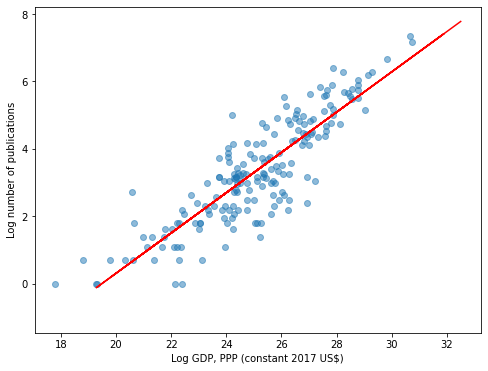

In [26]:
# Scatter of GDP pc and number of publications
x = np.log(df_merged["NY.GDP.MKTP.PP.KD"].values)
y = np.log(df_merged["papers"].values)
idx = np.isfinite(x) & np.isfinite(y) # to exclude observations with nan in wdi data
m,b = np.polyfit(x[idx], y[idx], 1)
plt.figure(figsize=(8, 6))
plt.scatter(x, y,  alpha=0.5) #s=area, c=colors,
plt.plot(x, m*x + b, color = "red")
plt.xlabel("Log GDP, PPP (constant 2017 US$)")
plt.ylabel("Log number of publications")
plt.show()

C:\Users\wb469649\AppData\Local\Temp\ipykernel_13568\2490735751.py:3: RuntimeWarning: divide by zero encountered in log
  y = np.log(df_merged["papers"].values)


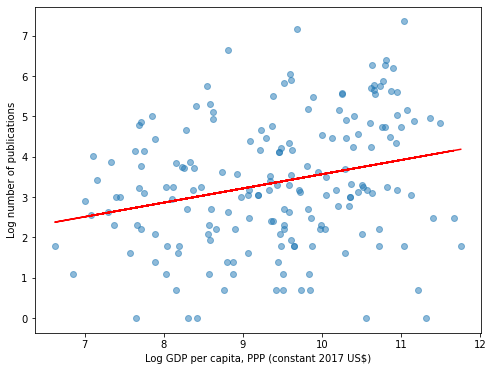

In [27]:
# Scatter of GDP pc and number of publications
x = np.log(df_merged["NY.GDP.PCAP.PP.KD"].values)
y = np.log(df_merged["papers"].values)
idx = np.isfinite(x) & np.isfinite(y) # to exclude observations with nan in wdi data
m,b = np.polyfit(x[idx], y[idx], 1)
plt.figure(figsize=(8, 6))
plt.scatter(x, y,  alpha=0.5) #s=area, c=colors,
plt.plot(x, m*x + b, color = "red")
plt.xlabel("Log GDP per capita, PPP (constant 2017 US$)")
plt.ylabel("Log number of publications")
plt.show()

C:\Users\wb469649\AppData\Local\Temp\ipykernel_13568\704282292.py:3: RuntimeWarning: divide by zero encountered in log
  y = np.log(df_merged["papers"].values)


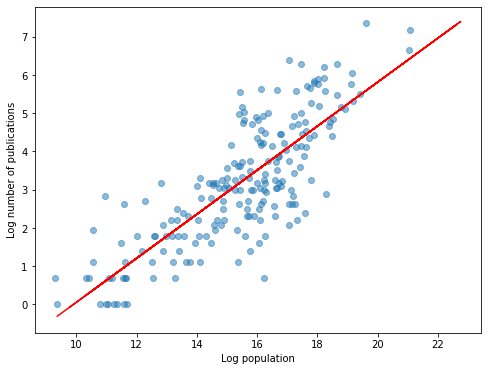

In [28]:
# Scatter of population and number of publications
x = np.log(df_merged["SP.POP.TOTL"].values)
y = np.log(df_merged["papers"].values)
idx = np.isfinite(x) & np.isfinite(y) # to exclude observations with nan in wdi data
m,b = np.polyfit(x[idx], y[idx], 1)
plt.figure(figsize=(8, 6))
plt.scatter(x, y,  alpha=0.5) #s=area, c=colors,
plt.plot(x, m*x + b, color = "red")
plt.xlabel("Log population")
plt.ylabel("Log number of publications")
plt.show()

## Classify Papers by Data Use - 'Naive' Approach with Regular Expressions

### Classification

We first try a 'naive' approach. We assume that if any of the following words appear in the title, abstract, or topics field, the paper uses data. If none of the words appear, the paper doesn't use data. The apporoach is case-insensitive.

Reference word list 1: data

Reference word list 2: data, survey, census

Reference word list 3: data, survey, census, panel, cross-section, time-series

Reference word list 4: data, survey, census, panel, cross-section, time-series, ...

Reference word list 4 is inspired 'statistical terms' in Paris21 (2021) (saved in the literature folder).

In [29]:
%%time
print("Working on list 1 ...")
df_final["data_use_1"] = df_pd["abstract"].str.contains('data', flags=re.IGNORECASE, regex=True).astype(int)
print("Working on list 2 ...")
df_final["data_use_2"] = df_pd["abstract"].str.contains('data|survey|census', flags=re.IGNORECASE, regex=True).astype(int)
print("Working on list 3 ...")
df_final["data_use_3"] = df_pd["abstract"].str.contains('data|survey|census|panel|cross.*?section|time.*?series', flags=re.IGNORECASE, regex=True).astype(int)
print("Working on list 4 ...")
reference_word_list_4 = "data|survey|census|panel|cross.*?section|Multinomial|Logit|Estimator|Cohort.*?level|Nonlinear|Covariance|Variance|Residual|Sampling|Sample|Instrumental Variable|Kernel|Probit|Poisson|Panel|Quantile|Arellano.*?bond|Confounding|Non.*?random|Randomisation|Statistical Significance|Statistically Significant|Statistical Power|Autoregressive|Fixed.*?Effects|First.*?differences|Central Limit|Stochastic|Autocorrelation|Upward Bias|Downward Bias|Difference.*?in.*?Difference|Bayes|Endogenous|Misspecification|Imputation|Semiparametric|Mean|Mode|Median|Confidence Interval|P.*?value|Heteroskedastic|Time series|Parameter|Granger|Multivariate|Cluster|Chi.*?square|Dummy|Deviation|Coefficient|Likelihood|Conditional|Ceteris.*?paribus|Regression|Data|Cross.*?section|Heckman|Heterogeneity|Residual|Hot deck|Cold deck|standard error|standard deviation|Longitudinal|Counterfactual|Propensity|Exogenous|Microdata|Regressor|Multicollinearity|Attrition|Odds ratio|Polynomial|Propensity|score|Quasi.*?experiment|Treatment group|Control group|BLUE|OLS|metric|indicator|outcome measure|random forest|lasso|ridge|test error|out.*?of.*?sample|neural net"
df_final["data_use_4"] = df_pd["abstract"].str.contains(reference_word_list_4, flags=re.IGNORECASE, regex=True).astype(int)
print("Done")

#df_pd["data_use_1"] = df_pd["text"].str.contains('data', flags=re.IGNORECASE, regex=True).astype(int)
#df_pd["data_use_1"] = df_pd["text"].str.contains('data', flags=re.IGNORECASE, regex=True).astype(int)

Working on list 1 ...
Working on list 2 ...
Working on list 3 ...
Working on list 4 ...
Done
CPU times: total: 1min 31s
Wall time: 1min 32s


In [30]:
#get index of countries with data_use_4 = 1
data_use_index=df_final[df_final["data_use_4"] == 1].index

#filter countries with data_use_4 = 1
df_c_data_use_4 = df_c.loc[data_use_index]

#get country numbers based on df_c_mturk
df_s_data_use_4 = df_c_data_use_4.sum().to_frame(name = "data_use_class_papers")

# Show 50 countries with highest number of publications
df_s_data_use_4 = df_s_data_use_4.sort_values(by = "data_use_class_papers", ascending = False)

In [31]:
df_merged = df_merged.join(df_s_data_use_4, how='left')


C:\Users\wb469649\AppData\Local\Temp\ipykernel_13568\2953521698.py:3: RuntimeWarning: divide by zero encountered in log
  y = np.log(df_merged["data_use_class_papers"].values)


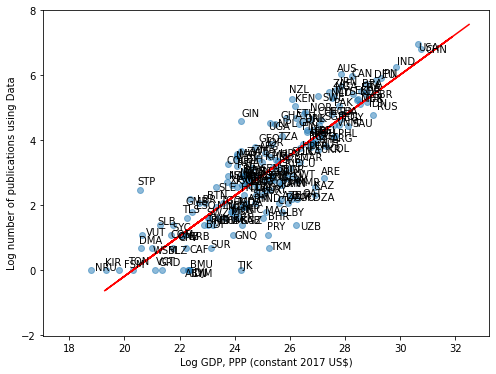

In [32]:
# Scatter of GDP pc and number of publications
x = np.log(df_merged["NY.GDP.MKTP.PP.KD"].values)
y = np.log(df_merged["data_use_class_papers"].values)
txt=df_merged.index.to_list()

idx = np.isfinite(x) & np.isfinite(y) # to exclude observations with nan in wdi data
m,b = np.polyfit(x[idx], y[idx], 1)
plt.figure(figsize=(8, 6))
plt.scatter(x, y,  alpha=0.5) #s=area, c=colors,
plt.plot(x, m*x + b, color = "red")
for i, lab in enumerate(txt):
    plt.annotate(lab, (x[i]+random.uniform(-0.2, 0.2), y[i]+random.uniform(-0.2, 0.2)))
plt.xlabel("Log GDP, PPP (constant 2017 US$)")
plt.ylabel("Log number of publications using Data")
plt.show()

C:\Users\wb469649\AppData\Local\Temp\ipykernel_13568\1223870625.py:3: RuntimeWarning: divide by zero encountered in log
  y = np.log(df_merged["data_use_class_papers"].values)


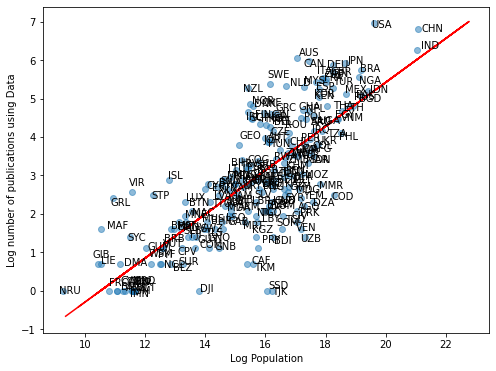

In [33]:
df_pd.columns# Scatter of GDP pc and number of publications
x = np.log(df_merged["SP.POP.TOTL"].values)
y = np.log(df_merged["data_use_class_papers"].values)
txt=df_merged.index.to_list()

idx = np.isfinite(x) & np.isfinite(y) # to exclude observations with nan in wdi data
m,b = np.polyfit(x[idx], y[idx], 1)
plt.figure(figsize=(8, 6))
plt.scatter(x, y,  alpha=0.5) #s=area, c=colors,
plt.plot(x, m*x + b, color = "red")
for i, lab in enumerate(txt):
    plt.annotate(lab, (x[i]+random.uniform(-0.2, 0.2), y[i]+random.uniform(-0.2, 0.2)))
plt.xlabel("Log Population")
plt.ylabel("Log number of publications using Data")
plt.show()

In [34]:
random.uniform(-1, 1)

-0.6288486058049838

C:\Users\wb469649\AppData\Local\Temp\ipykernel_13568\281977977.py:3: RuntimeWarning: divide by zero encountered in log
  y = np.log(df_merged["data_use_class_papers"].values)


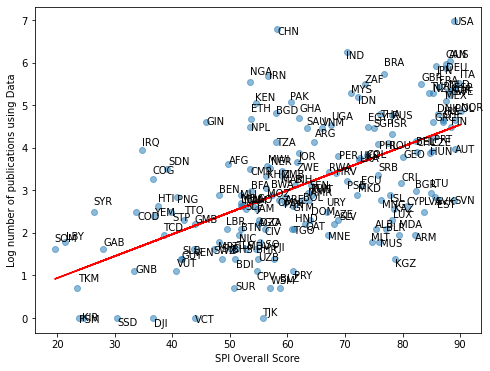

In [35]:
df_pd.columns# Scatter of SPI and number of publications
x = df_merged["IQ.SPI.OVRL"].values
y = np.log(df_merged["data_use_class_papers"].values)
idx = np.isfinite(x) & np.isfinite(y) # to exclude observations with nan in wdi data
m,b = np.polyfit(x[idx], y[idx], 1)
plt.figure(figsize=(8, 6))
plt.scatter(x, y,  alpha=0.5) #s=area, c=colors,
plt.plot(x, m*x + b, color = "red")
for i, lab in enumerate(txt):
    plt.annotate(lab, (x[i]+random.uniform(-0.2, 0.2), y[i]+random.uniform(-0.2, 0.2)))
plt.xlabel("SPI Overall Score")
plt.ylabel("Log number of publications using Data")
plt.show()

In [36]:
#linear regression

x = df_merged["NY.GDP.MKTP.PP.KD"]
y = df_merged["data_use_class_papers"]
x = sm.add_constant(x)

model = sm.OLS(y, x, missing='drop').fit()
predictions = model.predict(x) 
#calculate residuals
residuals = y - predictions

print_model = model.summary()
print(print_model)

                              OLS Regression Results                             
Dep. Variable:     data_use_class_papers   R-squared:                       0.797
Model:                               OLS   Adj. R-squared:                  0.796
Method:                    Least Squares   F-statistic:                     749.1
Date:                   Thu, 04 Aug 2022   Prob (F-statistic):           5.15e-68
Time:                           07:48:59   Log-Likelihood:                -1057.3
No. Observations:                    193   AIC:                             2119.
Df Residuals:                        191   BIC:                             2125.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const   

In [37]:
#Multiple regression
import statsmodels.formula.api as smf



df_reg=df_merged[['data_use_class_papers', 'SP.POP.TOTL','NY.GDP.MKTP.PP.KD', 'IQ.SPI.OVRL']]
df_reg.columns=['data_use_class_papers', 'Population','GNI', 'SPI_overall_score']

x = df_reg[['Population','GNI', 'SPI_overall_score']]
y = df_reg["data_use_class_papers"].values
x = sm.add_constant(x)

model = sm.OLS(y, x, missing='drop').fit()
predictions = model.predict(x) 

#calculate residuals
residuals = y - predictions


print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     265.8
Date:                Thu, 04 Aug 2022   Prob (F-statistic):           3.83e-63
Time:                        07:48:59   Log-Likelihood:                -925.55
No. Observations:                 170   AIC:                             1859.
Df Residuals:                     166   BIC:                             1872.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -49.5541     17.06

C:\Users\wb469649\AppData\Local\Temp\ipykernel_13568\425012889.py:2: RuntimeWarning: divide by zero encountered in log
  x = np.log(df_reg["data_use_class_papers"].values)


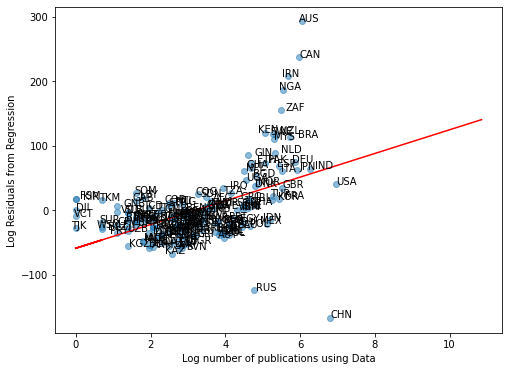

In [38]:
# Scatter of residuals from regression
x = np.log(df_reg["data_use_class_papers"].values)
y = residuals
txt=df_merged.index.to_list()


idx = np.isfinite(x) & np.isfinite(y) # to exclude observations with nan in wdi data
m,b = np.polyfit(x[idx], y[idx], 1)
plt.figure(figsize=(8, 6))
plt.scatter(x, y,  alpha=0.5) #s=area, c=colors,
plt.plot(x, m*x + b, color = "red")
for i, lab in enumerate(txt):
    plt.annotate(lab, (x[i]+random.uniform(-0.2, 0.2), y[i]+random.uniform(-0.2, 0.2)))
plt.ylabel("Log Residuals from Regression")
plt.xlabel("Log number of publications using Data")
plt.show()

In [39]:
df_merged.reset_index().to_csv(country_file)
